In [81]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print(dataset)
print(dataset.len())
print(dataset.num_classes)
print(dataset.num_features)
print(dataset.num_node_features)

KarateClub()
1
4
34
34


In [83]:
data = dataset[0] # get the first graph.
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [84]:
print(data.x.shape) # M * F 样本数 * 特征数
print(data.edge_index.shape) # source -> target * 边数
print(data.train_mask) # 样本是否有标签

torch.Size([34, 34])
torch.Size([2, 156])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


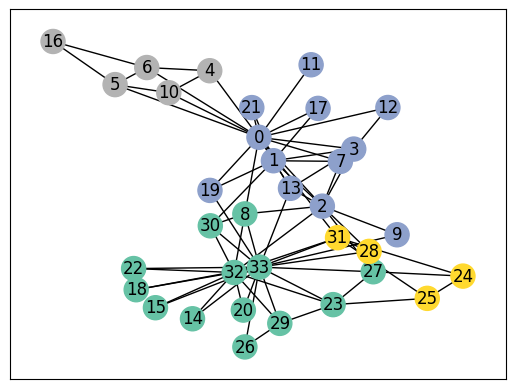

In [85]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, node_color=data.y, cmap="Set2")

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)
    
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index) # 特征和邻接矩阵
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        
        out = self.classifier(h)
        
        return out, h

In [90]:
def visualize_embedding(h, color, epoch, loss):
    plt.title(f'epoch={epoch}, loss={loss}')
    h_np = h.detach().numpy()
    plt.scatter(h_np[:,0], h_np[:,1], c=color, cmap='Set2')
    plt.show()

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
Embedding shape: [34, 2]


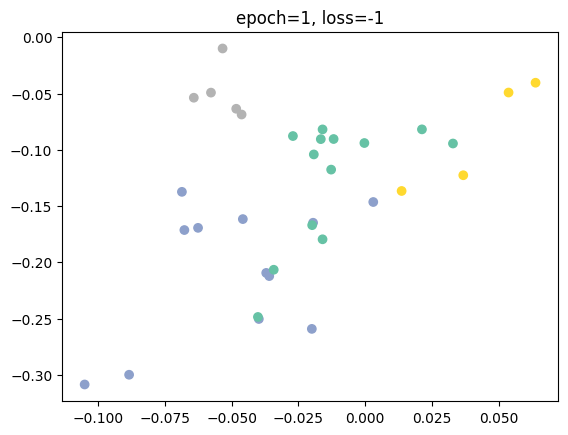

In [91]:
model = GCN()
print(model)
out, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, data.y, 1, -1)


## 训练模型

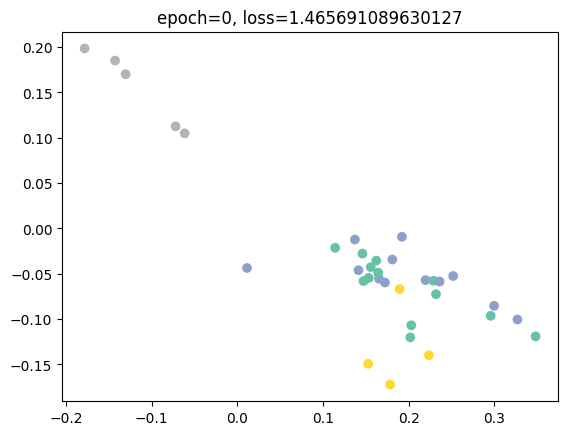

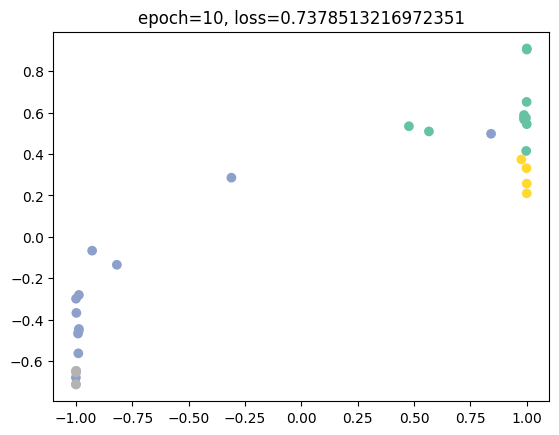

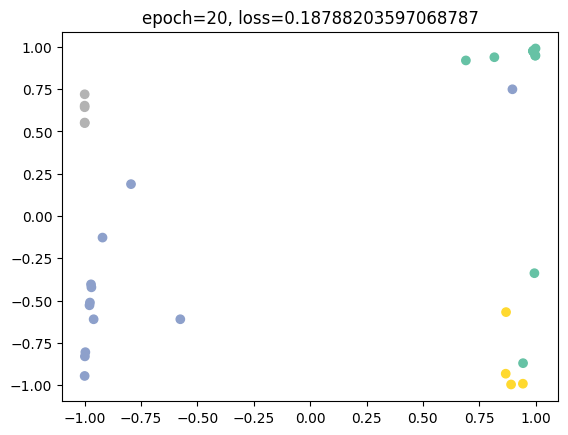

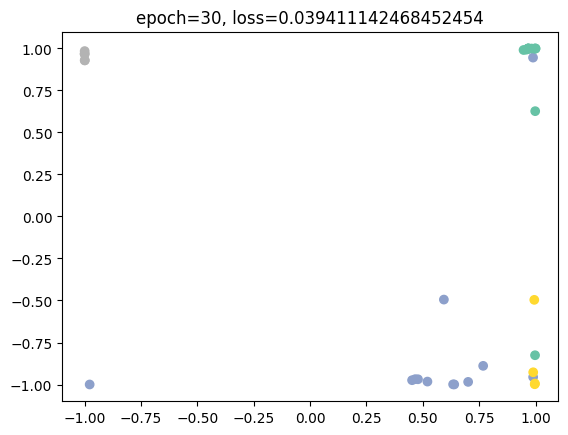

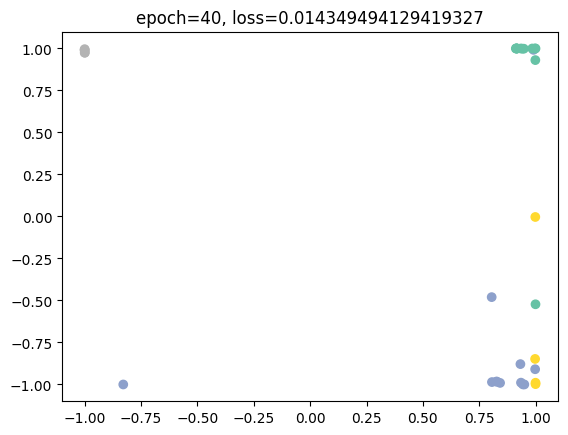

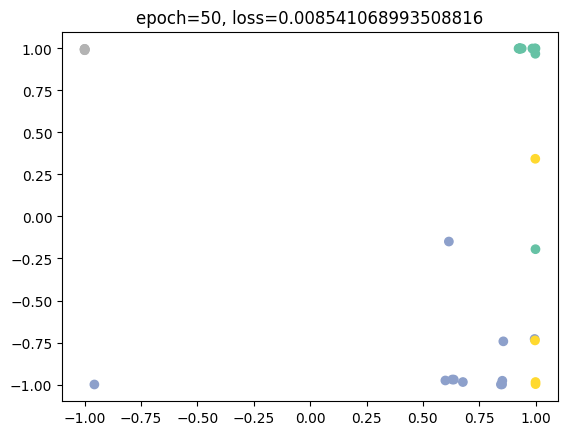

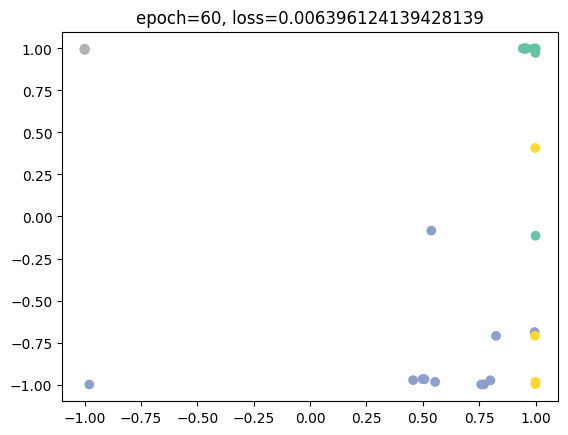

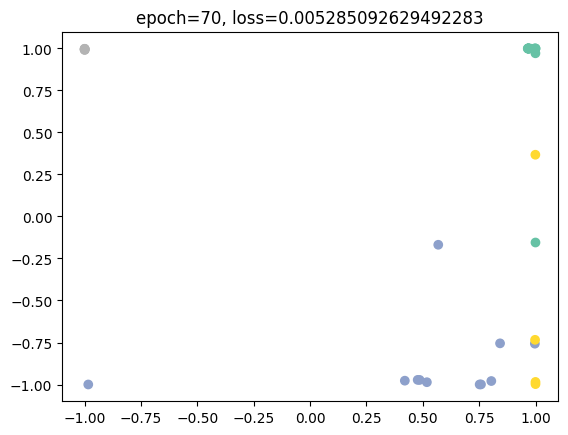

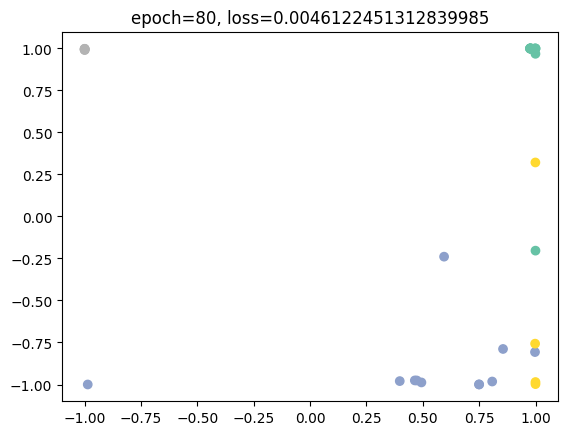

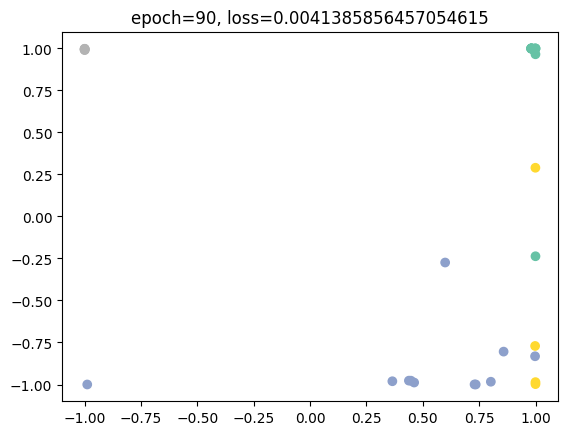

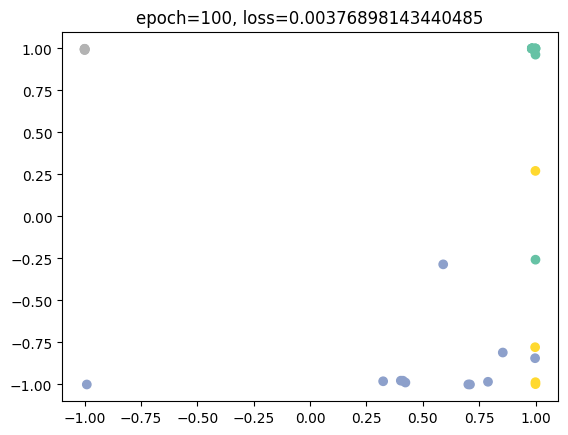

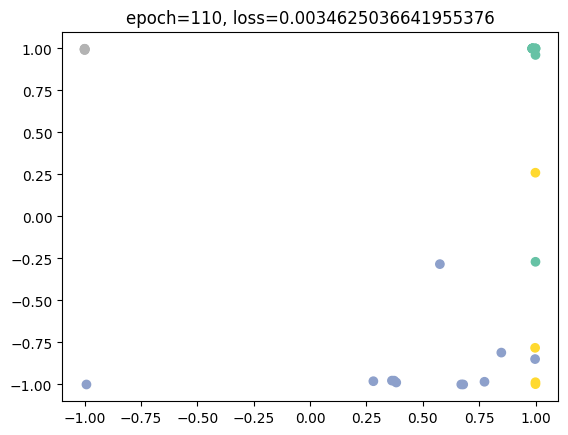

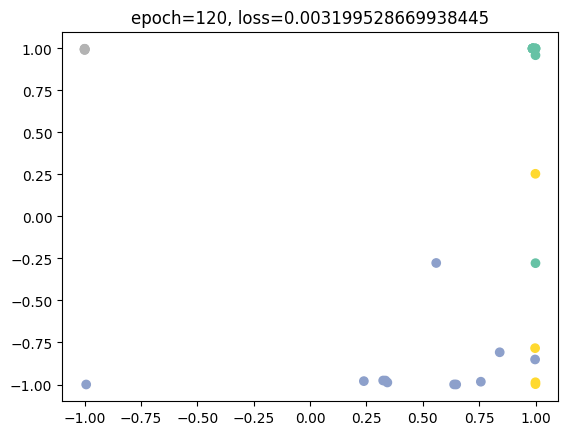

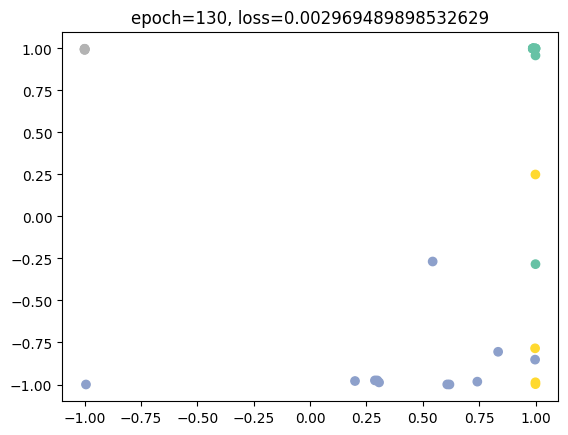

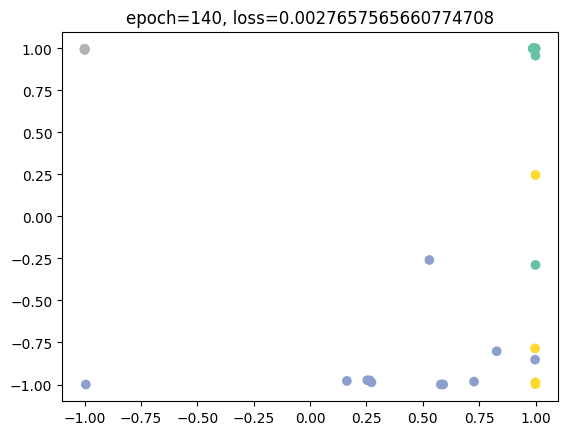

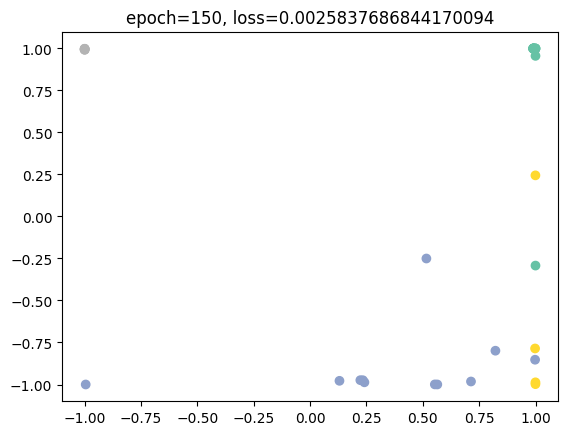

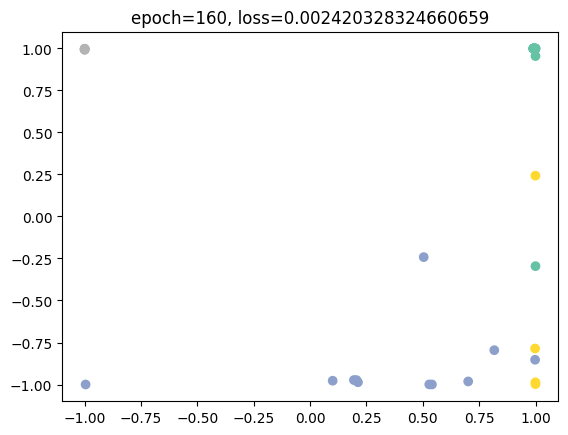

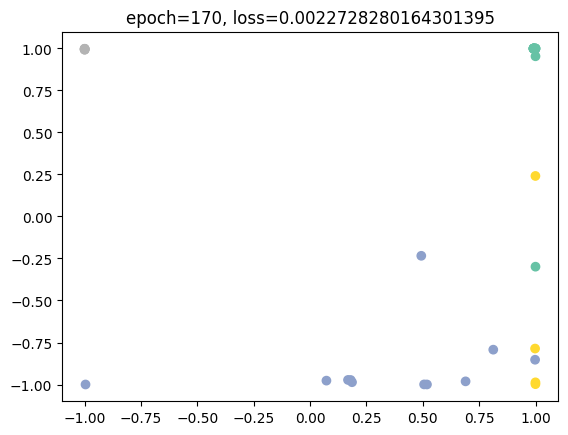

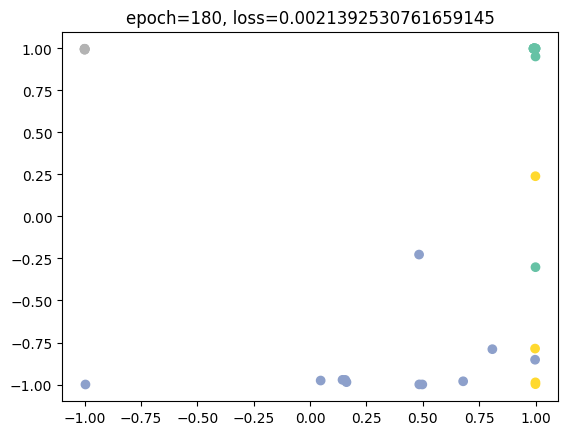

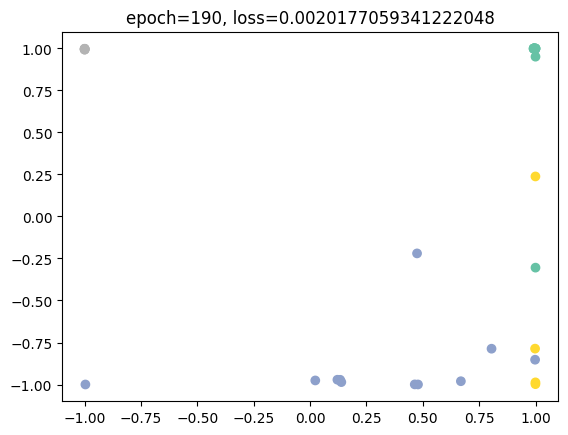

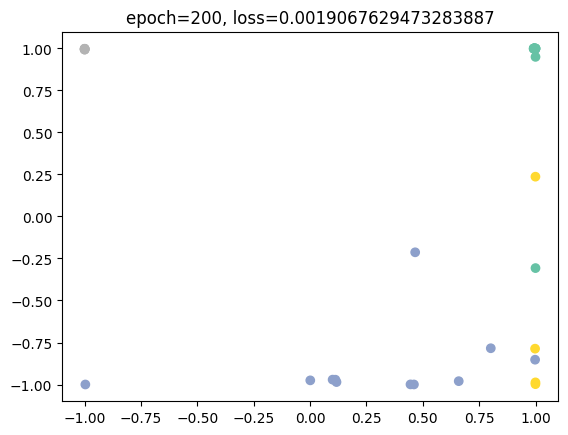

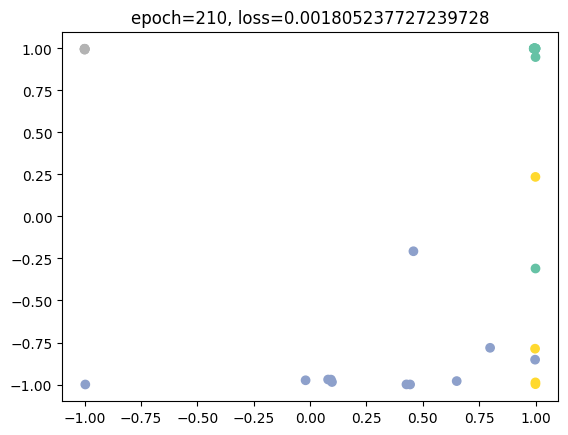

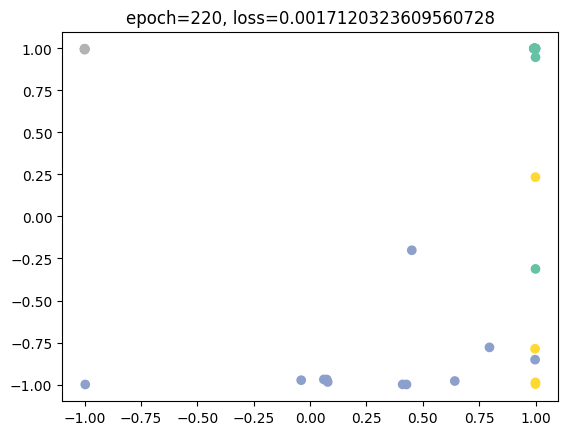

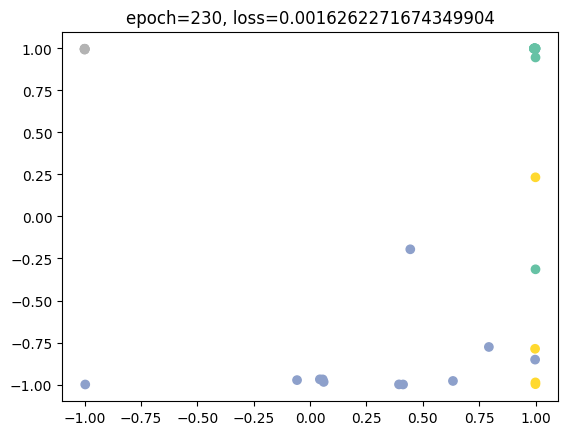

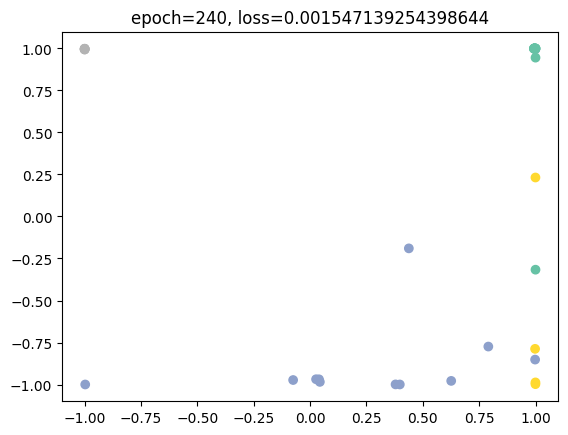

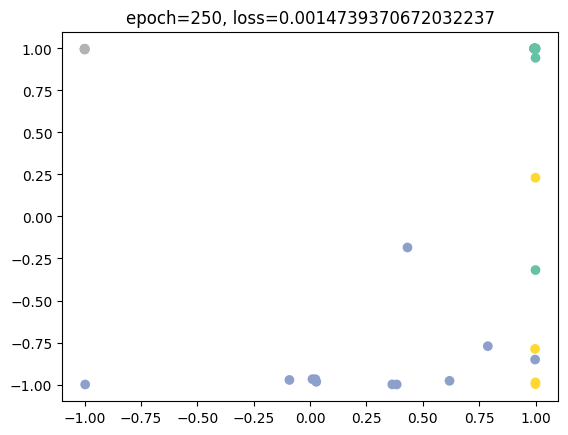

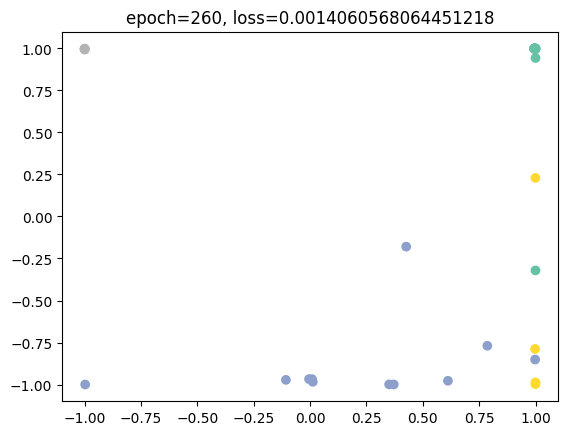

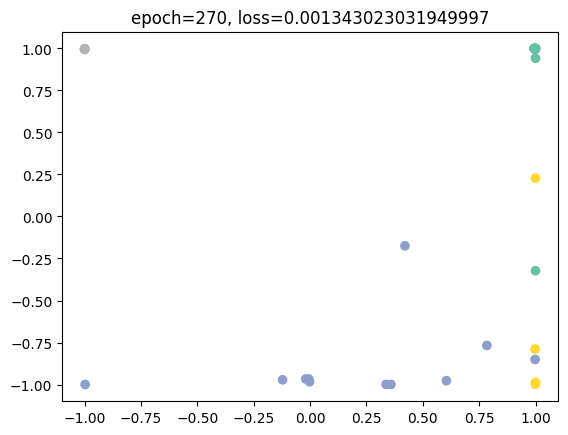

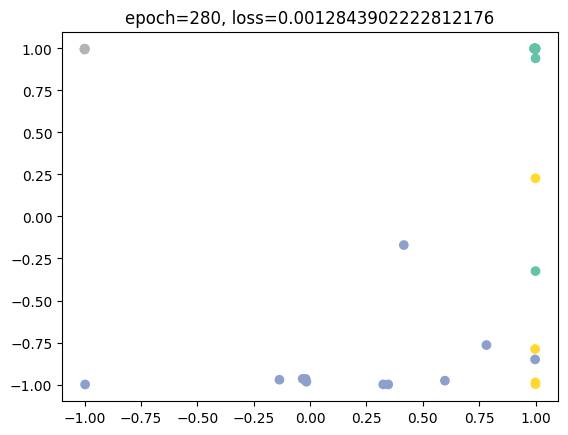

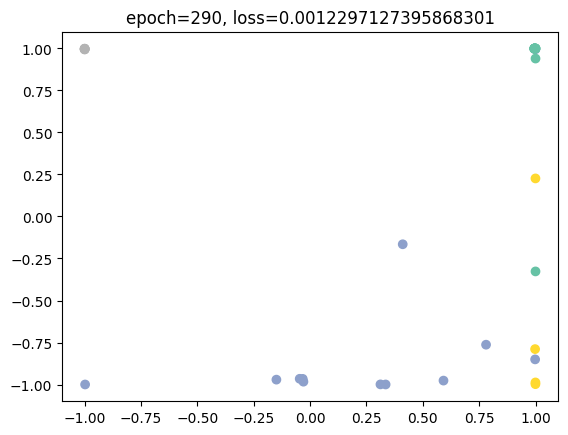

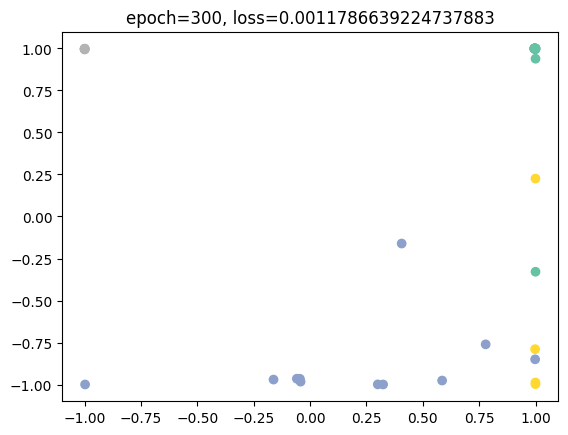

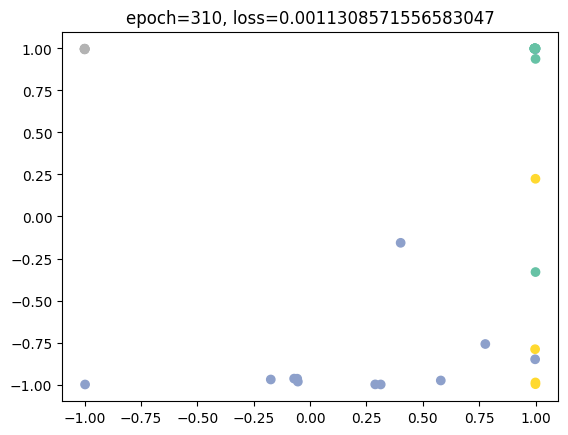

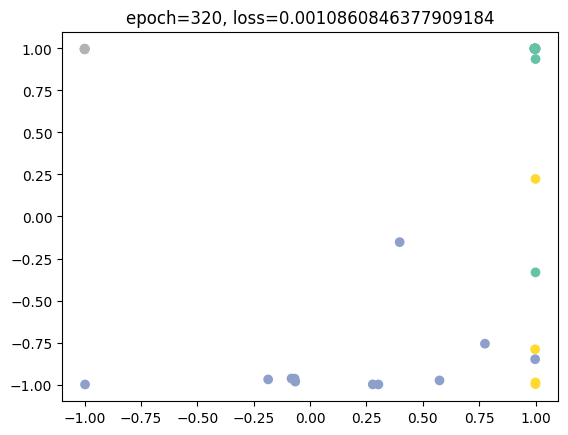

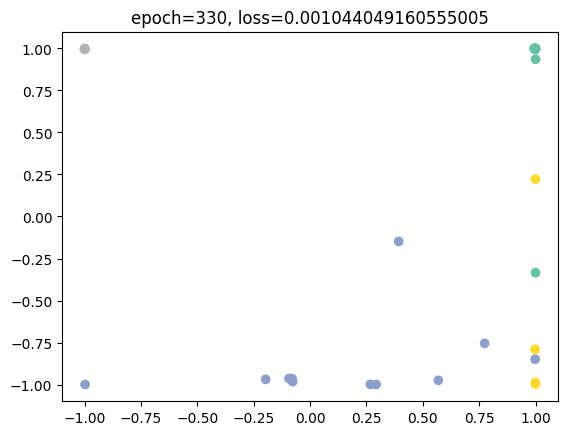

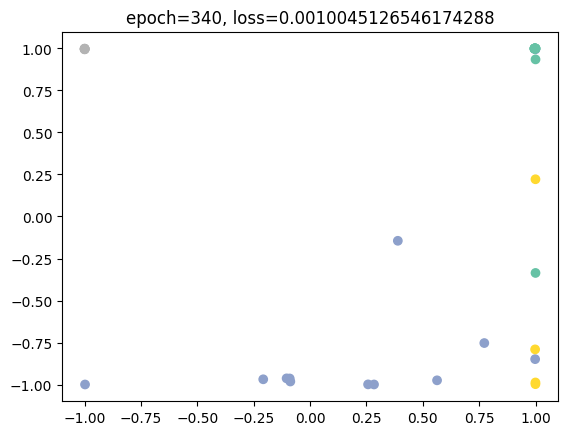

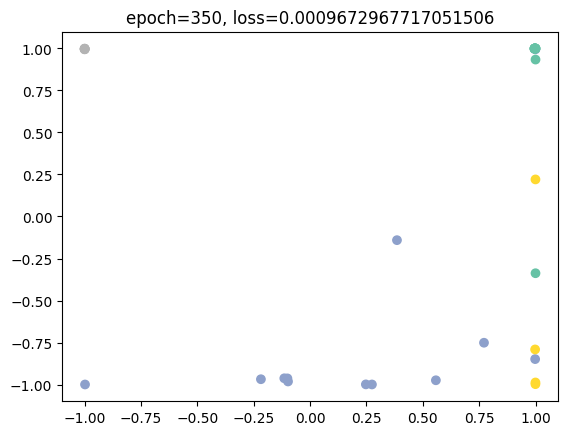

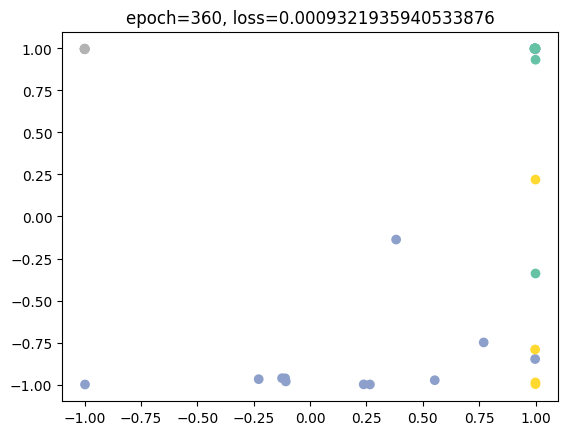

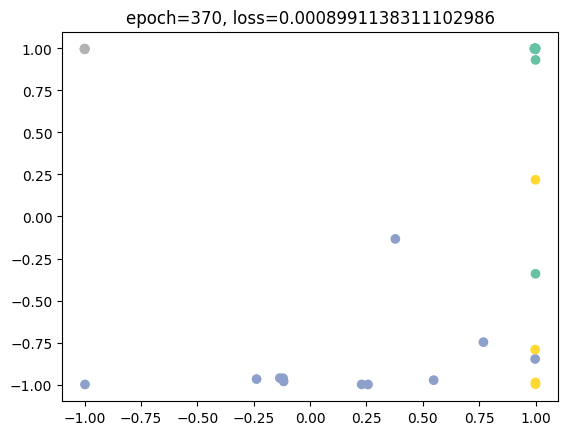

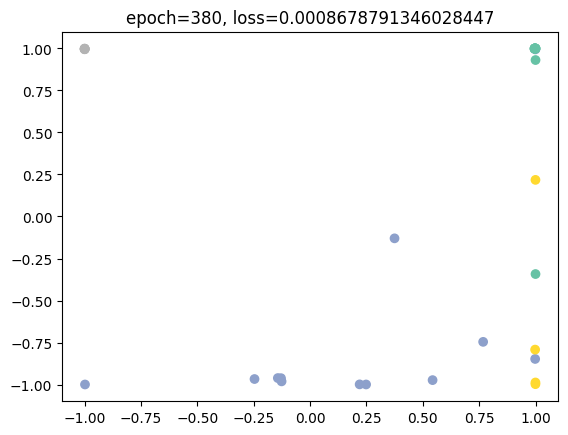

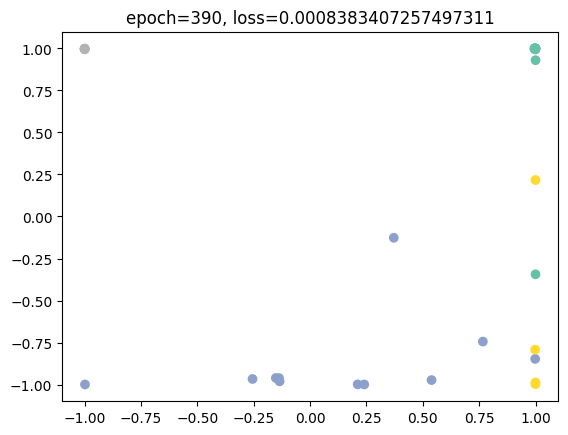

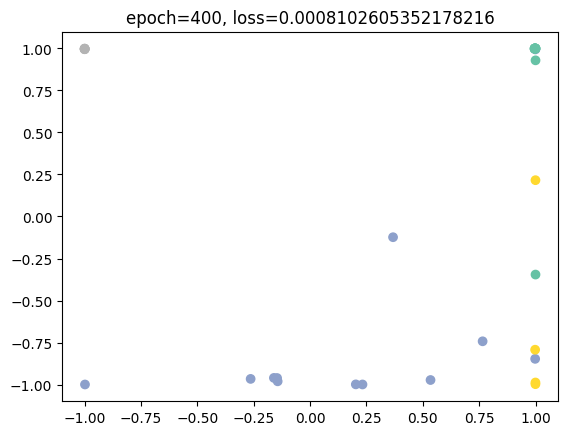

In [92]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.1)

def train(data):
    opt.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # semi-supervised
    loss.backward()
    opt.step()
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, data.y, epoch, loss)
        time.sleep(0.3)
    